In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics as sk_met
from sklearn.cluster import KMeans


import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Hotel Market Segmentation through Unsupervised Learning

## Project Overview

This project applies advanced clustering techniques to analyze and segment hotels based on their service offerings, amenities, and pricing structures. The goal is to identify natural market segments that may differ from traditional star-based classifications, providing valuable insights for strategic positioning and marketing.

### Dataset Characteristics

- **39 hotels** from various locations
- **6 numerical features**: Comfort, Room Count, Cuisine Quality, Sports Facilities, Beach Access, and Price
- **Traditional classification**: Star ratings (0-5 stars)
- **Objective**: Identify natural groupings beyond star ratings

### Analytical Methodology

This study employs a comprehensive unsupervised learning approach:

1. **Exploratory Data Analysis** - Correlation analysis and data distribution examination
2. **Dimensionality Reduction** - Principal Component Analysis (PCA) for visualization and for clustering implementation
3. **Clustering Algorithms**:
   - Hierarchical Clustering for natural structure identification
   - K-Means Clustering for optimal segment definition
4. **Validation Metrics** - Silhouette scores and Adjusted Rand Index (ARI) for quality assessment

### Key Research Question

- How well do star ratings align with data-driven clustering results?


### Technical Implementation

This project demonstrates proficiency in:
- Data preprocessing and standardization
- Multiple clustering methodologies
- Dimensionality reduction techniques
- Cluster validation and interpretation
- Business insight generation from analytical results

In [16]:
# Load dataset
hotels_df = pd.read_csv('hotels.csv')

# Variables for later analysis
names = hotels_df['NOM']
pays = hotels_df['PAYS'] 
etoile = hotels_df['ETOILE']

# Numerical variables for clustering
hotels_var = hotels_df.drop(columns=['NOM', 'PAYS', 'ETOILE'])
features = hotels_var.columns

print("📊 Dataset loaded successfully")
print(f"Dimensions: {hotels_df.shape}")
print(f"Variables for clustering: {list(features)}")
print("\nFirst 5 rows:")
hotels_df.head()

📊 Dataset loaded successfully
Dimensions: (39, 9)
Variables for clustering: ['CONFORT', 'CHAMBRE', 'CUISINE', 'SPORT', 'PLAGE', 'PRIX']

First 5 rows:


,NOM,PAYS,ETOILE,CONFORT,CHAMBRE,CUISINE,SPORT,PLAGE,PRIX
0,Appolpon,Grece,1,4,56,2,0,8,390
1,Caravel,Grece,4,7,471,7,6,5,468
2,Christina,Grece,2,7,93,3,0,5,427
3,Economy,Grece,1,3,56,1,0,8,369
4,EdenBeach,Grece,1,4,286,3,4,7,499


## Exploratory Analysis and Correlations

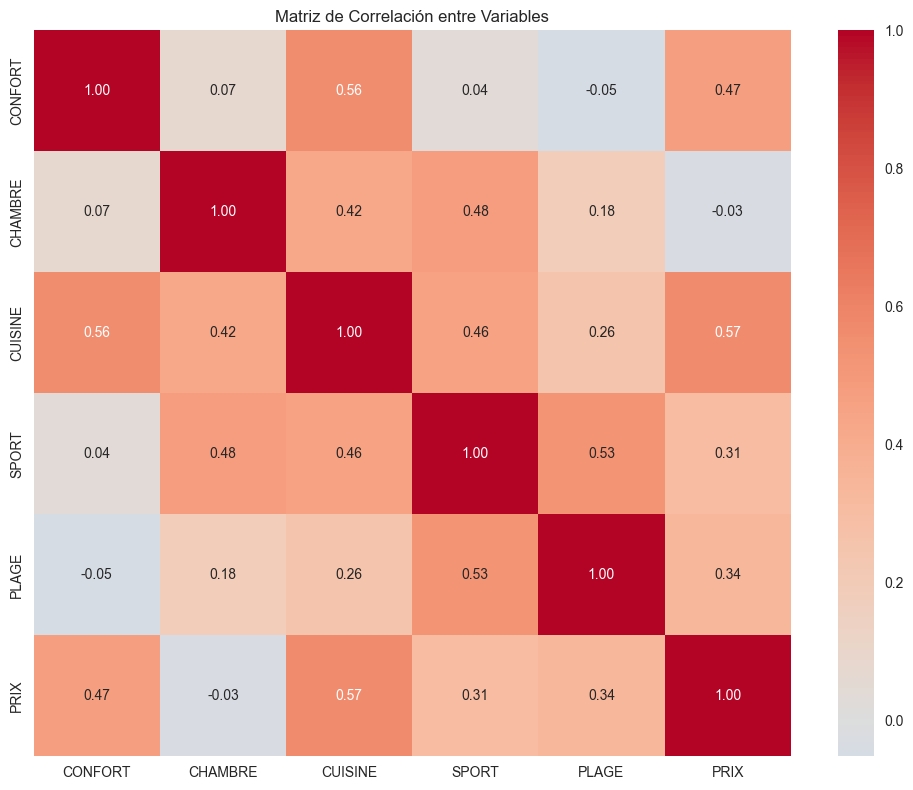

🔍 STRONGEST CORRELATIONS:
CUISINE  PRIX       0.567485
PRIX     CUISINE    0.567485
CONFORT  CUISINE    0.558688
dtype: float64

WEAKEST CORRELATIONS:
CHAMBRE  PRIX      -0.034912
CONFORT  PLAGE     -0.051668
PLAGE    CONFORT   -0.051668
dtype: float64


In [19]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = hotels_var.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación entre Variables')
plt.tight_layout()
plt.show()

# Identify strongest correlations
print("🔍 STRONGEST CORRELATIONS:")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs != 1.0]  # Remove self-correlations
print(corr_pairs.head(3))
print("\nWEAKEST CORRELATIONS:")
print(corr_pairs.tail(3))

In [20]:
# Convert to numpy and standardize
hotel_np = hotels_var.to_numpy()
scaler = StandardScaler()
hotel_np_transformed = scaler.fit_transform(hotel_np)

print("✅ Data standardized successfully")
print(f"Original dimension: {hotel_np.shape}")
print(f"Standardized data stats - Mean: {hotel_np_transformed.mean():.2f}, Std: {hotel_np_transformed.std():.2f}")

✅ Data standardized successfully
Original dimension: (39, 6)
Standardized data stats - Mean: -0.00, Std: 1.00


## PCA Analysis

In [21]:
# Apply PCA
pca = PCA(n_components=2)
hotel_transformed = pca.fit_transform(hotel_np_transformed)

# Explained variance
variance_pc1 = pca.explained_variance_ratio_[0] * 100
variance_pc2 = pca.explained_variance_ratio_[1] * 100
total_variance = variance_pc1 + variance_pc2

print(f"📈 EXPLAINED VARIANCE:")
print(f"PC1: {variance_pc1:.1f}%")
print(f"PC2: {variance_pc2:.1f}%") 
print(f"Total: {total_variance:.1f}%")

📈 EXPLAINED VARIANCE:
PC1: 43.6%
PC2: 23.6%
Total: 67.1%


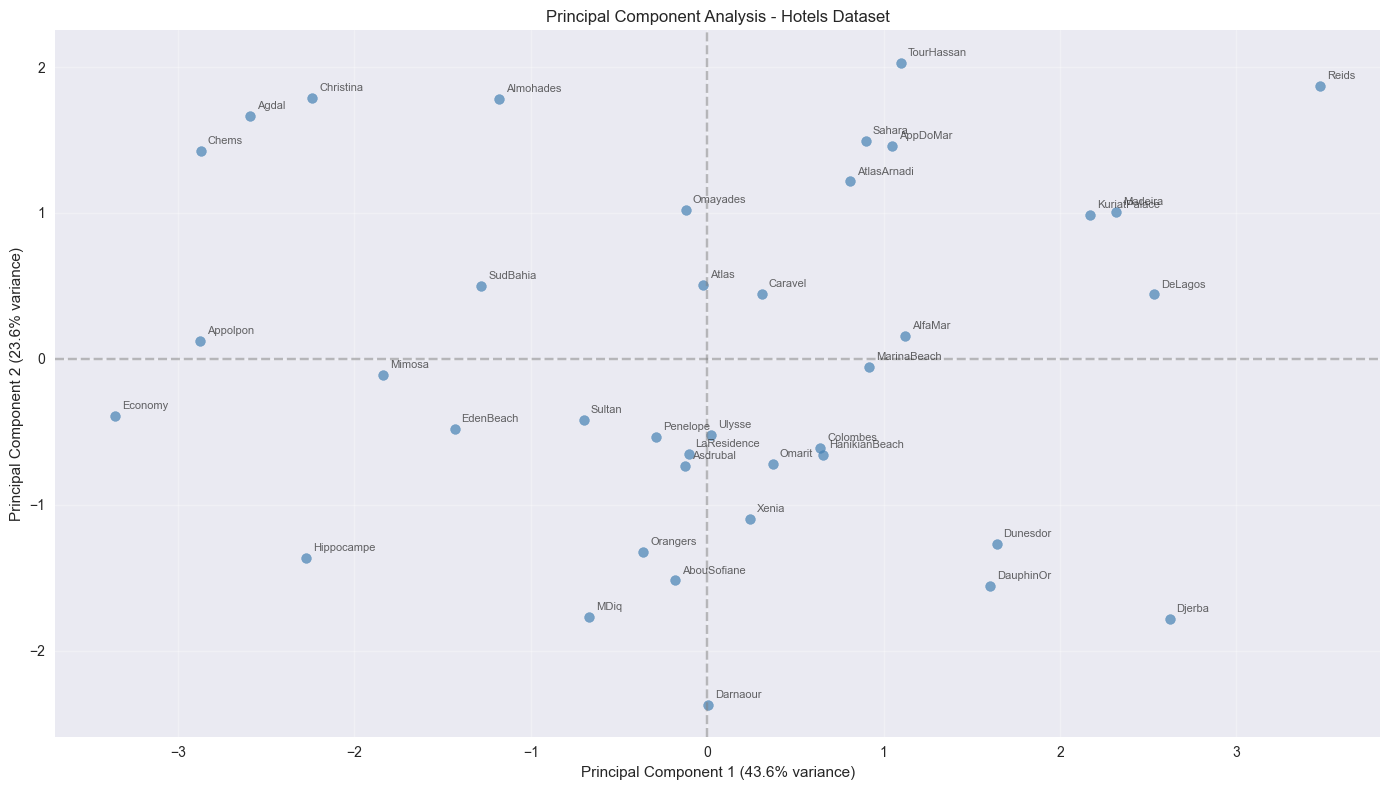

In [22]:
# PCA plot with labels
plt.figure(figsize=(14, 8))
plt.scatter(hotel_transformed[:, 0], hotel_transformed[:, 1], s=50, alpha=0.7, c='steelblue')

# Hotel labels
for i, name in enumerate(names):
    plt.annotate(name, 
                (hotel_transformed[i, 0], hotel_transformed[i, 1]),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8,
                alpha=0.7)

plt.axhline(0, color='grey', linestyle='--', alpha=0.5)
plt.axvline(0, color='grey', linestyle='--', alpha=0.5)
plt.xlabel(f'Principal Component 1 ({variance_pc1:.1f}% variance)')
plt.ylabel(f'Principal Component 2 ({variance_pc2:.1f}% variance)')
plt.title('Principal Component Analysis - Hotels Dataset')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Hierarchical Clustering - Method Comparison

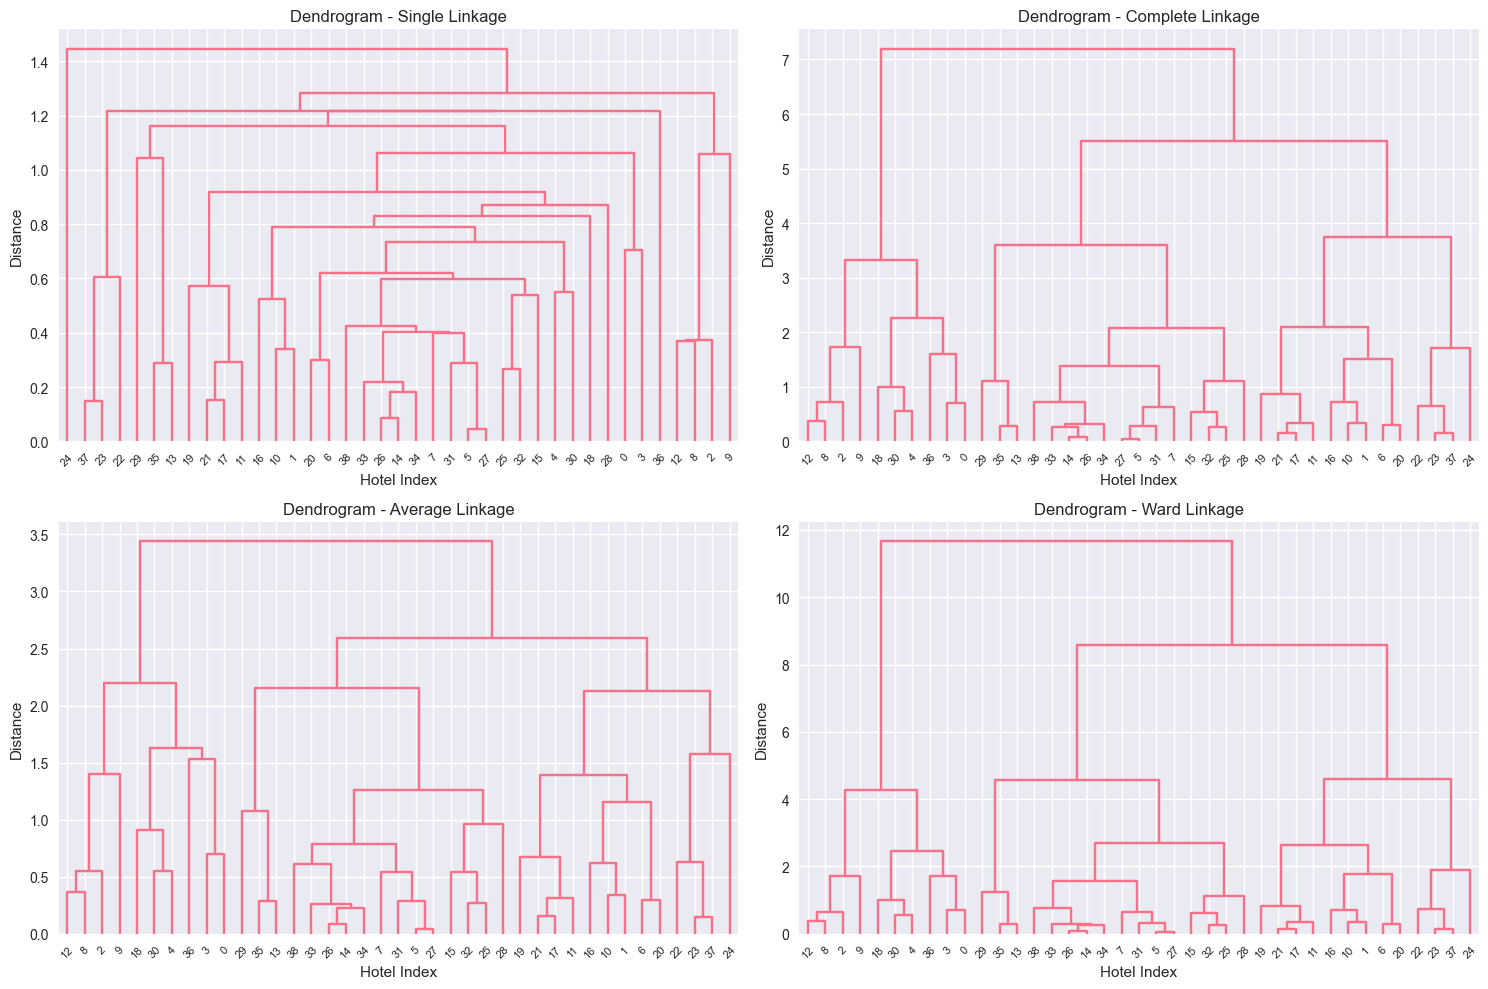

In [23]:
# Compare linkage methods
methods = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(15, 10))
for i, method in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    cluster = linkage(hotel_transformed, method=method, metric='euclidean', optimal_ordering=True)
    dendrogram(cluster, color_threshold=0)
    plt.title(f'Dendrogram - {method.capitalize()} Linkage')
    plt.xlabel('Hotel Index')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()

Using the complete method, we find a better structure, very similar to Ward's, but for the moment this one will be used.

In [24]:
# Apply hierarchical clustering with complete method (best visual result)
method = 'complete'
cluster = linkage(hotel_transformed, method=method, metric='euclidean', optimal_ordering=True)

# Define threshold and get clusters
threshold = 3
hierarchical_labels = fcluster(cluster, threshold, criterion='distance')

# Calculate metrics
silhouette_hierarchical = sk_met.silhouette_score(hotel_transformed, hierarchical_labels)

print(f"🔬 METHOD: {method}")
print(f"📏 THRESHOLD: {threshold}")
print(f"📊 NUMBER OF CLUSTERS: {len(np.unique(hierarchical_labels))}")
print(f"⭐ SILHOUETTE SCORE: {silhouette_hierarchical:.3f}")

🔬 METHOD: complete
📏 THRESHOLD: 3
📊 NUMBER OF CLUSTERS: 6
⭐ SILHOUETTE SCORE: 0.453


## K-Means - Optimal K Determination

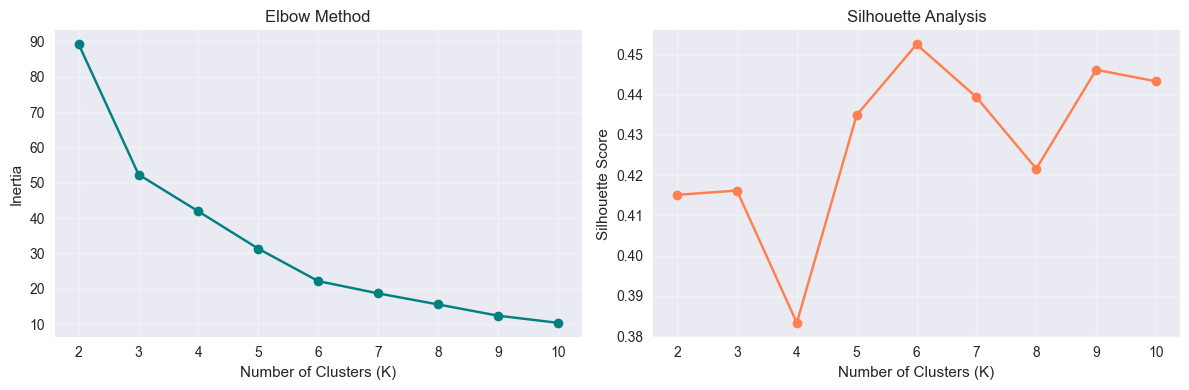

🎯 OPTIMAL K BASED ON SILHOUETTE: 6


In [25]:
# Elbow method and silhouette analysis for optimal K
inertias = []
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans_labels = kmeans.fit_predict(hotel_transformed)
    inertias.append(kmeans.inertia_)
    silhouettes.append(sk_met.silhouette_score(hotel_transformed, kmeans_labels))

# Comparative plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_range, inertias, marker='o', color='teal')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouettes, marker='o', color='coral')
ax2.set_title('Silhouette Analysis')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal K
optimal_k = k_range[np.argmax(silhouettes)]
print(f"🎯 OPTIMAL K BASED ON SILHOUETTE: {optimal_k}")

We choose k = 6 for now because the elbow method shows a sharp change in slope at k = 3 and k = 6, and the silhouette indicator shows a better result at k = 6.

## K-Means - Final Application

In [27]:
# Apply K-Means with optimal K
k_optimal = 6
kmeans_final = KMeans(n_clusters=k_optimal, init='k-means++', n_init=10, random_state=42)
kmeans_labels = kmeans_final.fit_predict(hotel_transformed)

# Final metrics
silhouette_kmeans = sk_met.silhouette_score(hotel_transformed, kmeans_labels)
ari_score = sk_met.adjusted_rand_score(etoile, kmeans_labels)

print(f"🎯 SELECTED OPTIMAL K: {k_optimal}")
print(f"📊 SILHOUETTE SCORE: {silhouette_kmeans:.3f}")
print(f"🔄 ARI vs STAR RATINGS: {ari_score:.3f}")

# Compare with hierarchical clustering
print(f"\n📈 COMPARISON WITH HIERARCHICAL CLUSTERING:")
print(f"K-Means Silhouette: {silhouette_kmeans:.3f}")
print(f"Hierarchical Silhouette: {silhouette_hierarchical:.3f}")

🎯 SELECTED OPTIMAL K: 6
📊 SILHOUETTE SCORE: 0.453
🔄 ARI vs STAR RATINGS: 0.179

📈 COMPARISON WITH HIERARCHICAL CLUSTERING:
K-Means Silhouette: 0.453
Hierarchical Silhouette: 0.453


## Comparative Cluster Visualization

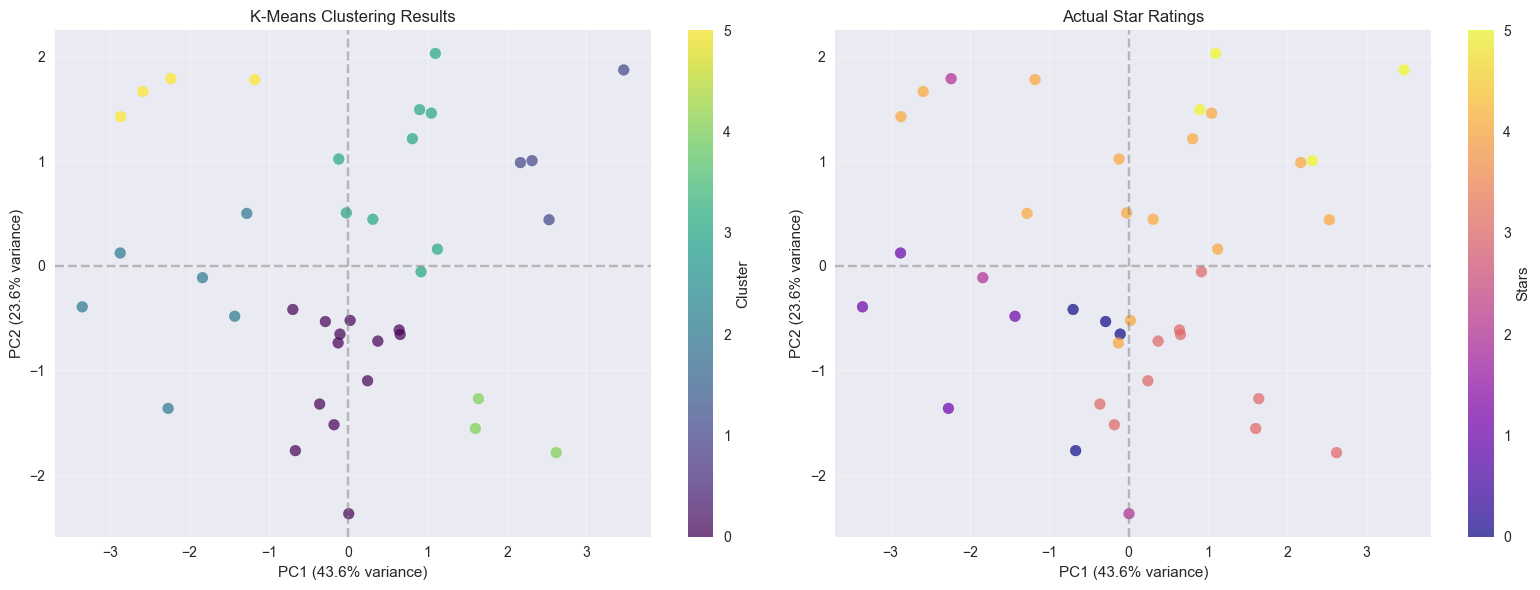

In [28]:
# Comparative plot: Clusters vs Actual Stars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-Means Clusters
scatter1 = ax1.scatter(hotel_transformed[:, 0], hotel_transformed[:, 1], 
                      c=kmeans_labels, cmap='viridis', s=60, alpha=0.7)
ax1.set_xlabel(f'PC1 ({variance_pc1:.1f}% variance)')
ax1.set_ylabel(f'PC2 ({variance_pc2:.1f}% variance)')
ax1.set_title('K-Means Clustering Results')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Actual Star Ratings
scatter2 = ax2.scatter(hotel_transformed[:, 0], hotel_transformed[:, 1], 
                      c=etoile, cmap='plasma', s=60, alpha=0.7)
ax2.set_xlabel(f'PC1 ({variance_pc1:.1f}% variance)')
ax2.set_ylabel(f'PC2 ({variance_pc2:.1f}% variance)')
ax2.set_title('Actual Star Ratings')
plt.colorbar(scatter2, ax=ax2, label='Stars')

# Common settings
for ax in [ax1, ax2]:
    ax.axhline(0, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(0, color='grey', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We found that the generated groups have no real correlation with the star system already assigned.

## Cluster Profile Analysis

In [29]:
# Create DataFrame for analysis
cluster_analysis = hotels_var.copy()
cluster_analysis['CLUSTER_KMEANS'] = kmeans_labels
cluster_analysis['HOTEL_NAME'] = names.values
cluster_analysis['STARS'] = etoile.values

# Statistics by cluster
cluster_stats = cluster_analysis.groupby('CLUSTER_KMEANS').agg({
    'CONFORT': 'mean',
    'CHAMBRE': 'mean',
    'CUISINE': 'mean', 
    'SPORT': 'mean',
    'PLAGE': 'mean',
    'PRIX': 'mean',
    'STARS': 'mean',
    'HOTEL_NAME': 'count'
}).round(2)

cluster_stats.rename(columns={'HOTEL_NAME': 'HOTEL_COUNT'}, inplace=True)

print("📈 CLUSTER STATISTICS (K-MEANS):")
print(cluster_stats)

📈 CLUSTER STATISTICS (K-MEANS):
                CONFORT  CHAMBRE  CUISINE  SPORT  PLAGE    PRIX  STARS  \
CLUSTER_KMEANS                                                           
0                  4.23   286.85     6.31   8.00   8.85  468.69   2.15   
1                  7.25   233.50    10.00   9.50  10.00  796.00   4.50   
2                  3.67   143.00     2.83   2.83   7.17  436.17   1.67   
3                  6.56   259.89     8.22   5.67   7.44  589.22   4.11   
4                  4.67   566.67     9.33  10.00  10.00  554.33   3.00   
5                  5.75   156.75     4.75   0.75   2.00  451.50   3.50   

                HOTEL_COUNT  
CLUSTER_KMEANS               
0                        13  
1                         4  
2                         6  
3                         9  
4                         3  
5                         4  


## Hotels by Cluster (K-Means)

In [30]:
# List hotels by cluster
print("🏨 HOTEL DISTRIBUTION BY CLUSTER (K-MEANS):")
print("=" * 55)

for cluster_num in range(k_optimal):
    cluster_hotels = cluster_analysis[cluster_analysis['CLUSTER_KMEANS'] == cluster_num]
    print(f"\nCLUSTER {cluster_num + 1} ({len(cluster_hotels)} hotels):")
    for idx, row in cluster_hotels.iterrows():
        print(f"  • {row['HOTEL_NAME']} - {row['STARS']}★")

🏨 HOTEL DISTRIBUTION BY CLUSTER (K-MEANS):

CLUSTER 1 (13 hotels):
  • HanikianBeach - 3★
  • Xenia - 3★
  • LaResidence - 0★
  • MDiq - 0★
  • AbouSofiane - 3★
  • Asdrubal - 4★
  • Colombes - 3★
  • Darnaour - 2★
  • Omarit - 3★
  • Orangers - 3★
  • Penelope - 0★
  • Ulysse - 4★
  • Sultan - 0★

CLUSTER 2 (4 hotels):
  • DeLagos - 4★
  • Madeira - 5★
  • Reids - 5★
  • KuriatPalace - 4★

CLUSTER 3 (6 hotels):
  • Appolpon - 1★
  • Economy - 1★
  • EdenBeach - 1★
  • SudBahia - 4★
  • Mimosa - 2★
  • Hippocampe - 1★

CLUSTER 4 (9 hotels):
  • Caravel - 4★
  • MarinaBeach - 3★
  • Atlas - 4★
  • AtlasArnadi - 4★
  • Omayades - 4★
  • Sahara - 5★
  • TourHassan - 5★
  • AlfaMar - 4★
  • AppDoMar - 4★

CLUSTER 5 (3 hotels):
  • Dunesdor - 3★
  • Djerba - 3★
  • DauphinOr - 3★

CLUSTER 6 (4 hotels):
  • Christina - 2★
  • Agdal - 4★
  • Almohades - 4★
  • Chems - 4★


In [31]:
# Identify interesting discrepancies
discrepancies = []
for i, (hotel, stars, cluster) in enumerate(zip(names, etoile, kmeans_labels)):
    cluster_stars_avg = cluster_stats.loc[cluster, 'STARS']
    if abs(stars - cluster_stars_avg) > 1.5:
        discrepancies.append((hotel, stars, cluster, cluster_stars_avg))

if discrepancies:
    print("\n🔍 INTERESTING CASES - Hotels that 'challenge' their category:")
    for hotel, stars, cluster, cluster_avg in discrepancies:
        print(f"  • {hotel}: {stars}★ but in cluster averaging {cluster_avg:.1f}★")
        print(f"    → Potentially overrated or underrated based on actual amenities")
else:
    print("\n✅ Most hotels cluster consistently with their star rating")


🔍 INTERESTING CASES - Hotels that 'challenge' their category:
  • LaResidence: 0★ but in cluster averaging 2.1★
    → Potentially overrated or underrated based on actual amenities
  • MDiq: 0★ but in cluster averaging 2.1★
    → Potentially overrated or underrated based on actual amenities
  • SudBahia: 4★ but in cluster averaging 1.7★
    → Potentially overrated or underrated based on actual amenities
  • Asdrubal: 4★ but in cluster averaging 2.1★
    → Potentially overrated or underrated based on actual amenities
  • Penelope: 0★ but in cluster averaging 2.1★
    → Potentially overrated or underrated based on actual amenities
  • Ulysse: 4★ but in cluster averaging 2.1★
    → Potentially overrated or underrated based on actual amenities
  • Sultan: 0★ but in cluster averaging 2.1★
    → Potentially overrated or underrated based on actual amenities


In [37]:
# Business implications
print("\n" + "="*60)
print("INSIGHTS AND RECOMMENDATIONS")
print("="*60)

print(f"""
KEY FINDINGS:
• Low ARI ({ari_score:.3f}) indicates star ratings DON'T fully explain hotel clustering
• Clusters are based on COMBINATIONS of features, not just stars
• Price doesn't always correlate directly with star ratings
• {len(discrepancies)} hotels significantly deviate from their expected category


TECHNICAL HIGHLIGHTS:
• K-Means++ showed better stability than random initialization
• PCA explained {total_variance:.1f}% variance with 2 components
• Optimal silhouette score achieved with K={k_optimal} clusters
• Hierarchical clustering validated natural data structure
""")


INSIGHTS AND RECOMMENDATIONS

KEY FINDINGS:
• Low ARI (0.179) indicates star ratings DON'T fully explain hotel clustering
• Clusters are based on COMBINATIONS of features, not just stars
• Price doesn't always correlate directly with star ratings
• 7 hotels significantly deviate from their expected category


TECHNICAL HIGHLIGHTS:
• K-Means++ showed better stability than random initialization
• PCA explained 67.1% variance with 2 components
• Optimal silhouette score achieved with K=6 clusters
• Hierarchical clustering validated natural data structure



In [38]:
# FINAL EXECUTIVE SUMMARY
print("="*70)
print("🎯 HOTEL SEGMENTATION ANALYSIS - EXECUTIVE SUMMARY")
print("="*70)

print(f"""
PROJECT OVERVIEW:
• Analyzed: {len(hotels_df)} hotels across multiple attributes
• Methods: PCA + Hierarchical Clustering + K-Means
• Goal: Identify natural hotel segments beyond star ratings

KEY METRICS:
• Optimal Clusters: {k_optimal}
• PCA Variance Explained: {total_variance:.1f}%
• Best Silhouette Score: {silhouette_kmeans:.3f}
• ARI vs Star Ratings: {ari_score:.3f}

MAIN INSIGHTS:
• Star ratings explain only {ari_score*100:.1f}% of the natural clustering
• {len(discrepancies)} hotels significantly deviate from their star category
• Price and amenities create more nuanced segments than stars alone

""")

🎯 HOTEL SEGMENTATION ANALYSIS - EXECUTIVE SUMMARY

PROJECT OVERVIEW:
• Analyzed: 39 hotels across multiple attributes
• Methods: PCA + Hierarchical Clustering + K-Means
• Goal: Identify natural hotel segments beyond star ratings

KEY METRICS:
• Optimal Clusters: 6
• PCA Variance Explained: 67.1%
• Best Silhouette Score: 0.453
• ARI vs Star Ratings: 0.179

MAIN INSIGHTS:
• Star ratings explain only 17.9% of the natural clustering
• 7 hotels significantly deviate from their star category
• Price and amenities create more nuanced segments than stars alone


